# Прогнозирование прибыли нефтяных скважин

«ГлавРосГосНефть» нужно решить, где бурить новую скважину<br>Для этого необходимо осуществить следующие шаги:
1. В избранном регионе собрать характеристики для скважин: качество нефти и объём её запасов;
2. Построить модель для предсказания объёма запасов в новых скважинах;
3. Выбрать скважины с самыми высокими оценками значений;
4. Определить регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой Bootstrap.

## Шаг 1. Обзор и обработка данных

*	id — уникальный идентификатор скважины;
*	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
*	product — объём запасов в скважине (тыс. баррелей).
Условия задачи:
*	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
*	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
*	Бюджет на разработку скважин в регионе — 10 млрд рублей.
*	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
*	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


In [35]:
import pandas as pd#
import numpy as np#
import matplotlib.pyplot as plt#
from sklearn.model_selection import train_test_split#
from sklearn.metrics import mean_squared_error#
from sklearn.preprocessing import StandardScaler#
from sklearn.linear_model import LinearRegression# модель линейная регрессия
from numpy.random import RandomState#функция для отключения повторения случайного элемента
import scipy.stats as st# функция для нахождения доверительного интервала для среднего

In [36]:
SPOTS = 500# кол-во исследуемых точек в регионе
BEST_SPOTS = 200# кол-во лучших точек для разработки, выбранных моделью
BUDGET = 10e9# бюджет на разработку скважин в регионе
INCOME = 450e3# доход с единицы продукта
LOSS_CHANCE = 0.025# порог вероятности убытков

In [37]:
#записываем данные из файла в переменную df
df_1 = pd.read_csv('D:\Yandex.Practicum\Машинное_обучение_в_бизнесе\Проект\geo_data_0.csv', sep=',')
df_2 = pd.read_csv('D:\Yandex.Practicum\Машинное_обучение_в_бизнесе\Проект\geo_data_1.csv', sep=',')
df_3 = pd.read_csv('D:\Yandex.Practicum\Машинное_обучение_в_бизнесе\Проект\geo_data_2.csv', sep=',')

In [38]:
df_1.info()
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [39]:
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [40]:
df_3.info()
df_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


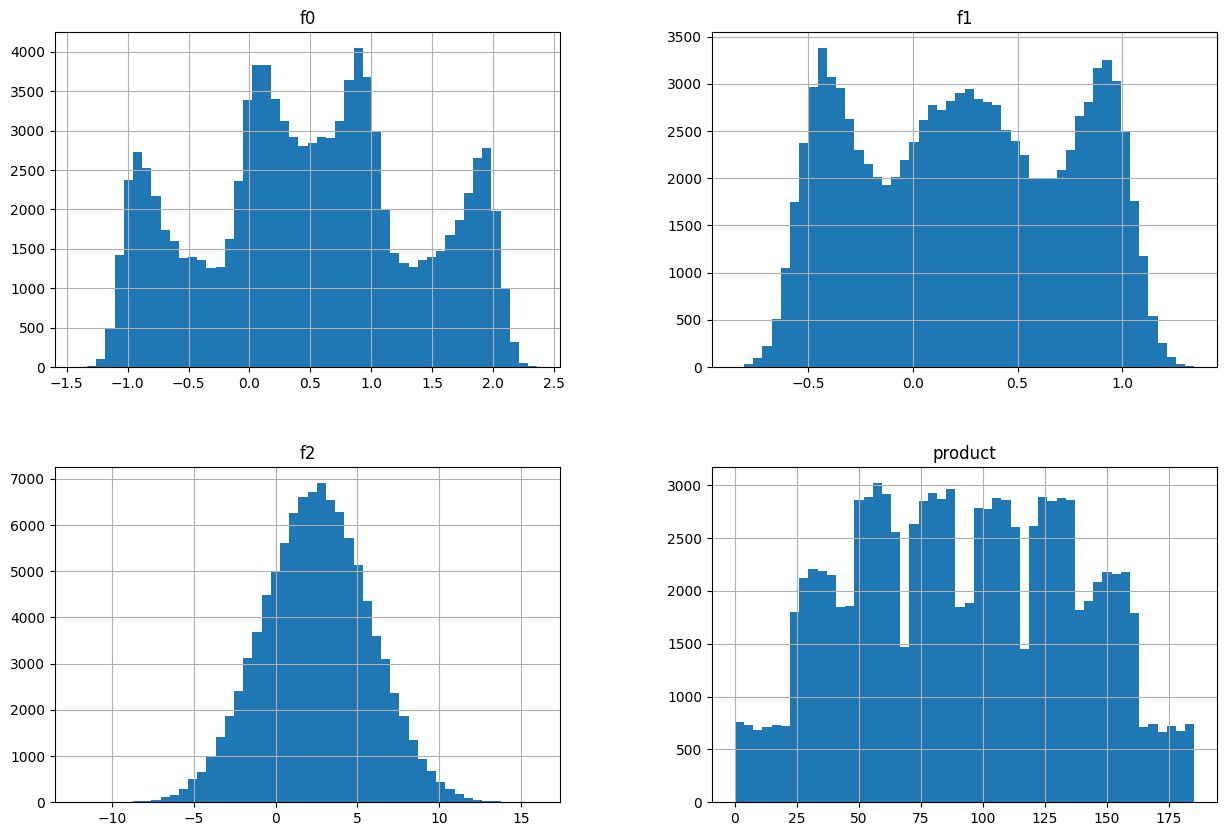

In [41]:
df_1.hist(bins=50, figsize=(15,10));

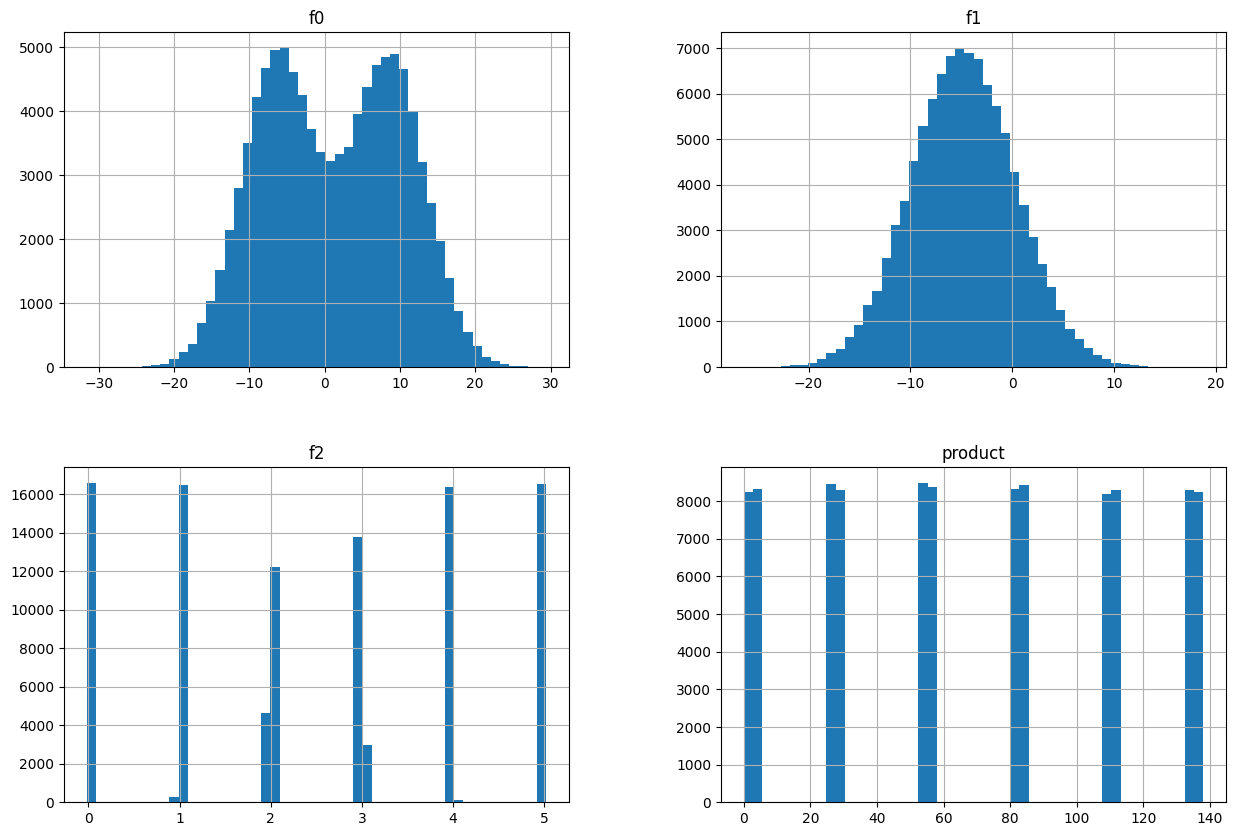

In [42]:
df_2.hist(bins=50, figsize=(15,10));

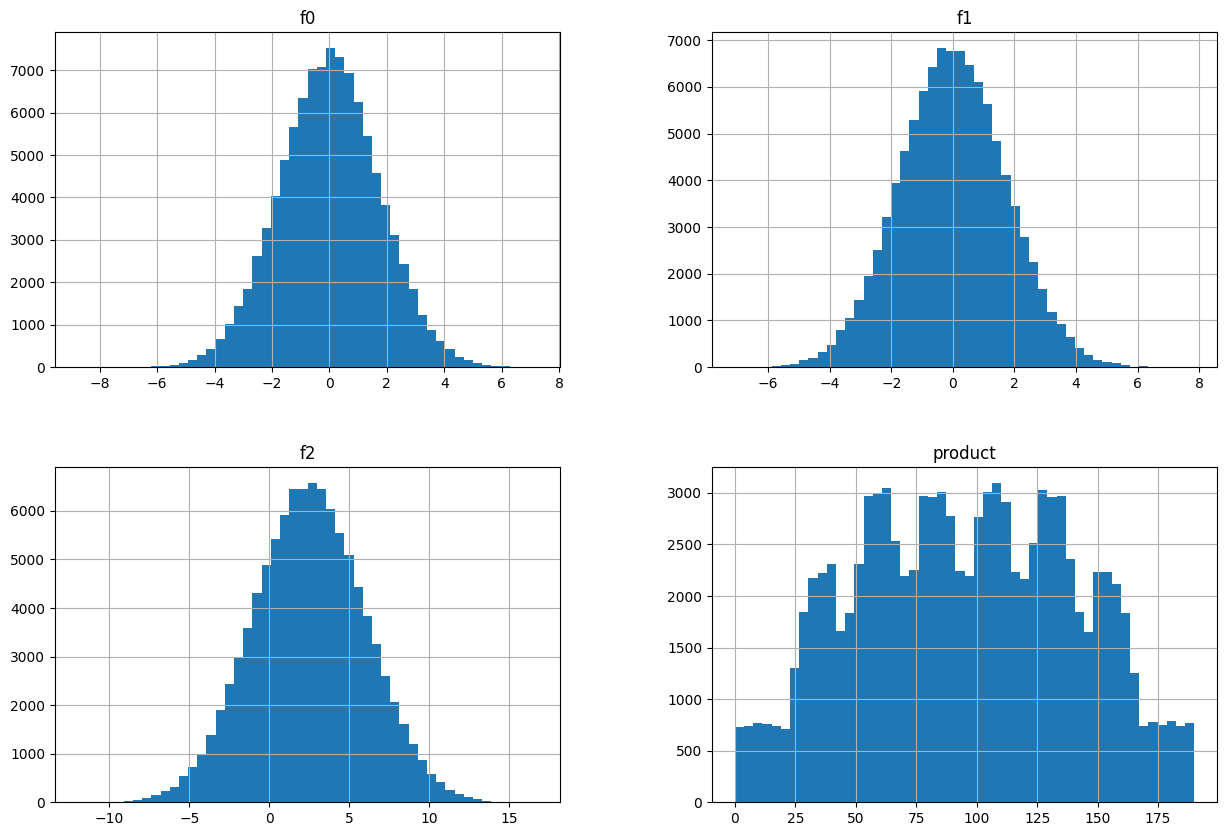

In [43]:
df_3.hist(bins=50, figsize=(15,10));

Первый и третий регионы очень похожи. Они имеют распределение по всей ширине интервала (Нормальное с небольшими выбросами и нормальное соответственно). Во втором регионе данные сосредоточены в 12 корзинах, что может говорить о более точных предсказаниях и вероятности найти выгодную скважину.

In [44]:
print(df_1[df_1.duplicated('id')])#выведем дубликаты строк
dup_df_1 = df_1[df_1.duplicated('id')]['id'].count()#кол-во дубликатов
dup_df_1

          id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302


10

In [46]:
#выведем все дубликаты с сортировкой по 'id' для удобства сравнения
df_1[df_1['id'].isin((df_1['id'].value_counts()==2)[:dup_df_1].index)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


В данных первого региона присутствуют месторождения с одинаковым *'id'*, но с разными признаками точек и объемом залежей нефти *'product'*  
Найдено всего 20 попарно-одинаковых скважин.  
Допустим, что такое кол-во данных не окажет влияние на обучение и предсказания модели.

In [47]:
print(df_2[df_2.duplicated('id')])#выведем дубликаты строк
dup_df_2 = df_2[df_2.duplicated('id')]['id'].count()#кол-во дубликатов
dup_df_2

          id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839  2.191999  3.993869  107.813044


4

In [48]:
#выведем все дубликаты с сортировкой по 'id' для удобства сравнения
df_2[df_2['id'].isin((df_2['id'].value_counts()==2)[:dup_df_2].index)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [49]:
print(df_3[df_3.duplicated('id')]) #выведем дубликаты строк 
dup_df_3 = df_3[df_3.duplicated('id')]['id'].count()#кол-во дубликатов
dup_df_3

          id        f0        f1        f2     product
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572


4

In [50]:
#выведем все дубликаты с сортировкой по 'id' для удобства сравнения
df_3[df_3['id'].isin((df_3['id'].value_counts()==2)[:dup_df_3].index)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В данных второго и третьего региона присутствуют месторождения с одинаковым *'id'*, но с разными признаками точек и объемом залежей нефти *'product'*  
Найдено всего по 4 попарно-одинаковых скважин.  
Допустим, что такое кол-во данных не окажет влияние на обучение и предсказания модели.

Выделим признаки для каждого региона для обучения моделей и поделим на выборки

In [51]:
regions = {'geo_1': df_1, 'geo_2': df_2, 'geo_3': df_3}#
regions_splitted = {}#

for key in regions.keys():
    features, target = regions[key].drop(['id', 'product'], axis=1), regions[key]['product']#
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)#
    regions_splitted[key] = [features_train, features_valid, target_train, target_valid]#

In [52]:
features_train_df_1, features_valid_df_1, target_train_df_1, target_valid_df_1 = regions_splitted['geo_1']#
features_train_df_2, features_valid_df_2, target_train_df_2, target_valid_df_2 = regions_splitted['geo_2']
features_train_df_3, features_valid_df_3, target_train_df_3, target_valid_df_3 = regions_splitted['geo_3']

In [53]:
print('Размеры переменных с признаками тренировочной выборки в трех регионах:')
for i in [features_train_df_1, features_train_df_2, features_train_df_3]:#
    print(i.shape)
print('Размеры переменных с признаками валидационной выборки в трех регионах:')
for i in [features_valid_df_1, features_valid_df_2, features_valid_df_3]:#
    print(i.shape)
print('Размеры переменных с целевым признаком тренировочной выборки в трех регионах:')
for i in [target_train_df_1, target_train_df_2, target_train_df_3]:#
    print(i.shape)
print('Размеры переменных с целевым признаком валидационной выборки в трех регионах:')
for i in [target_valid_df_1, target_valid_df_2, target_valid_df_3]:#
    print(i.shape)    

Размеры переменных с признаками тренировочной выборки в трех регионах:
(75000, 3)
(75000, 3)
(75000, 3)
Размеры переменных с признаками валидационной выборки в трех регионах:
(25000, 3)
(25000, 3)
(25000, 3)
Размеры переменных с целевым признаком тренировочной выборки в трех регионах:
(75000,)
(75000,)
(75000,)
Размеры переменных с целевым признаком валидационной выборки в трех регионах:
(25000,)
(25000,)
(25000,)


## Шаг 2. Обучение и проверка моделей для разных регионов

Обучим модели линейной регресии на данных каждого региона отдельно

In [54]:
model_geo_1 = LinearRegression()
model_geo_1.fit(features_train_df_1, target_train_df_1)
predictions_geo_1 = pd.Series(data=model_geo_1.predict(features_valid_df_1), index=target_valid_df_1.index)
print(f'Средний запас предсказанного сырья в первом регионе: {predictions_geo_1.mean()}\nRMSE модели: {mean_squared_error(target_valid_df_1, predictions_geo_1, squared=False)}')

Средний запас предсказанного сырья в первом регионе: 92.59256778438035
RMSE модели: 37.5794217150813


In [55]:
model_geo_2 = LinearRegression()
model_geo_2.fit(features_train_df_2, target_train_df_2)
predictions_geo_2 = pd.Series(data=model_geo_2.predict(features_valid_df_2), index=target_valid_df_2.index)
print(f'Средний запас предсказанного сырья во втором регионе: {predictions_geo_2.mean()}\nRMSE модели: {mean_squared_error(target_valid_df_2, predictions_geo_2, squared=False)}')

Средний запас предсказанного сырья во втором регионе: 68.72854689544602
RMSE модели: 0.8930992867756165


In [56]:
model_geo_3 = LinearRegression()
model_geo_3.fit(features_train_df_3, target_train_df_3)
predictions_geo_3 = pd.Series(data=model_geo_3.predict(features_valid_df_3), index=target_valid_df_3.index)
print(f'Средний запас предсказанного сырья в третьем регионе: {predictions_geo_3.mean()}\nRMSE модели: {mean_squared_error(target_valid_df_3, predictions_geo_3, squared=False)}')

Средний запас предсказанного сырья в третьем регионе: 94.96504596800489
RMSE модели: 40.02970873393434


По результатам предсказаний модели можно сказать, что второй регион практически безошибочно делает предсказания - ошибка составляет чуть больше 1% от среднего. Тогда как другие 2 региона имеют ошибку в примерно 40% от среднего. Кроме того показания 1-го и 3-го региона очень похожи.

In [57]:
df_1[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [58]:
df_2[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [59]:
df_3[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Высокий коэффициент корреляции f2 и целевого признака во втором регионе вероятно повлиял на размер ошибки.

## Шаг 3. Подготовка к расчету прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [60]:
print(f'Достаточный объем сырья: {BUDGET / BEST_SPOTS / INCOME:.2f} тыс. баррелей')

Достаточный объем сырья: 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе

In [61]:
print(f'Cредний запас сырья в первом регионе: {(target_valid_df_1.mean() + target_train_df_1.mean()) / 2:.2f} тыс. баррелей')

Cредний запас сырья в первом регионе: 92.36 тыс. баррелей


In [62]:
print(f'Cредний запас сырья во втором регионе: {(target_valid_df_2.mean() + target_train_df_2.mean()) / 2:.2f} тыс. баррелей')

Cредний запас сырья во втором регионе: 68.79 тыс. баррелей


In [63]:
print(f'Cредний запас сырья в третьем регионе: {(target_valid_df_3.mean() + target_train_df_3.mean()) / 2:.2f} тыс. баррелей')

Cредний запас сырья в третьем регионе: 94.96 тыс. баррелей


Ни в одном регионе средний запас сырья не превышает достаточный, хотя это и ни о чем не говорит, потому что средний запас рассчитан на основе всех точек (скважин), когда нам необходимо отобрать по 200 лучших. 

## Шаг 4. Расчёт прибыли по выбранным скважинам и предсказаниям модели

In [64]:
def income_counter(predicted, target_geo):
    best_index = predicted.sort_values(ascending=False)[:BEST_SPOTS].index#
    return target_geo[best_index].sum() * INCOME - BUDGET#

In [65]:
print(f'Прибыль 200 лучших скважин первого региона: {income_counter(predictions_geo_1, target_valid_df_1):.0f} руб.')

Прибыль 200 лучших скважин первого региона: 3320826043 руб.


In [66]:
print(f'Прибыль 200 лучших скважин второго региона: {income_counter(predictions_geo_2, target_valid_df_2):.0f} руб.')

Прибыль 200 лучших скважин второго региона: 2415086697 руб.


In [67]:
print(f'Прибыль 200 лучших скважин третьего региона: {income_counter(predictions_geo_3, target_valid_df_3):.0f} руб.')

Прибыль 200 лучших скважин третьего региона: 2710349964 руб.


При выборе 200 лучших точек из 25_000 самым прибыльным является первый регион, однако по условию мы можем исследовать только 500 точек, поэтому на данном этапе прогноз прибыли не точный.

## Шаг 5. Риски и прибыль каждого региона

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [79]:
state = RandomState(12345)#
def geo_bootstrap(predicted, target_geo, reg_num):
    income_list = []#
    for i in range(0, 1000):
        income_list.append(income_counter(predicted.sample(SPOTS, random_state=state, replace=True), target_geo))
    income_list = pd.Series(income_list)
    print(f'Средняя прибыль в регионе {reg_num}: {income_list.mean():.0f}')#
    print(f'95% доверительный интервал: {income_list.quantile(0.025):.2f}, {income_list.quantile(0.0975):.2f}')#
    print(f'Риск убытков: {income_list[income_list < 0].count() / income_list.count():.2%}')

In [80]:
geo_bootstrap(predictions_geo_1, target_valid_df_1, 1)

Средняя прибыль в регионе 1: 396164985
95% доверительный интервал: -111215545.89, 53834549.79
Риск убытков: 6.90%


In [81]:
geo_bootstrap(predictions_geo_2, target_valid_df_2, 2)

Средняя прибыль в регионе 2: 461155817
95% доверительный интервал: 78050810.75, 212855420.64
Риск убытков: 0.70%


In [82]:
geo_bootstrap(predictions_geo_3, target_valid_df_3, 3)

Средняя прибыль в регионе 3: 392950475
95% доверительный интервал: -112227625.38, 54436533.11
Риск убытков: 6.50%


# Вывод

Для того, чтобы выбрать регион для разработки скважины была проделана следующая работа:  
1. Загрузка данных и проведение общего анализа. Выявлена отличительное распределение данных во 2-ом регионе;  
2. Подготовка данных к обучению модели и обучение модели регрессии. Наиболее точные предсказания показала модель по второму региону;  
3. Подготовка константных переменных (в начале проекта) и расчет объёма сырья для безубыточной разработки новой скважины. Ни в одном регионе объем сырья не превзошел необходимый;  
4. Расчет прибыли по выбранным моделью скважинам и предсказаниям. Самым прибыльным оказался первый регион, однако это лишь в условиях исследования 25_000 точек, что не соответствует условиям задачи (500 точек);  
5. С применеием техники Bootstrap были посчитаны средние прибыли по регионам на основе случайных подвыборок из 500 точек, 95%-й доверительный интервал и риск убытков.

По результатам расчетов можно сказать, что самым подходящим является второй регион. Он имее найменьший шанс получить убытки и найбольшую, значительно отличающуюся от осьальных регионов, прибыль. Также доверительный интервал второго региона полностью лежит в положительной области, в то время как остальные регионы захватывают и отрицательную. Плюсом ко всему данные во втором регионе оказались самыми предсказуемыми.  
Поэтому на данный момент при условии, что необходимо просто не уйти в минус, лучше всего подходит 2-й регион. при более сложном подходе и требованиях выйти на максимально возможную прибыль стоит использовать другие методы обучения, чтобы использовать в конечном итоге всю выборку, а не 25%, тогда, вероятно, первый регион составит конкуренцию, так как средняя по выборке у него выше.